In [116]:
import pandas as pd
import numpy as np
import os

In [117]:
res_dict = {}
dates = ['060623', '060823']
models = ['rf', 'xgb', 'nn']
for date in dates:
    for model in models:
        try:
            res_dict[str(model)+'_'+str(date)] = pd.read_csv(f'runs/pdx/res_{model}_{date}.csv', index_col=0)
        except:
            pass

In [118]:
res_dict['xgb_060623'].head()

,drug,outcome,data_type,val_auroc,test_auroc_mean,test_auroc_ci,test_auprc_mean,test_auprc_ci
0,ib,OS,comb,0.742255,0.601541,0.5600149023395223-0.6430663301534748,0.845403,0.8147396102878394-0.8760670246255552
0,ib,OS,comb,0.742047,0.614846,0.5735703763859054-0.656121500364795,0.842972,0.81211263083216-0.8738314586933116


In [119]:
#for each model type, concat the results from the two dates, unless there is only one date
for model in models:
    try:
        res_dict[model] = pd.concat([res_dict[model+'_'+dates[0]], res_dict[model+'_'+dates[1]]])
        res_dict[model]['model'] = model
        del res_dict[model+'_'+dates[0]]
        del res_dict[model+'_'+dates[1]]
    except:
        res_dict[model] = res_dict[model+'_'+dates[1]]
        res_dict[model]['model'] = model
        del res_dict[model+'_'+dates[1]]

In [120]:
res_comb = pd.concat(res_dict.values())
res_comb.head()

,drug,outcome,data_type,val_auroc,test_auroc_mean,test_auroc_ci,test_auprc_mean,test_auprc_ci,model
0,ib,OS,comb,0.699130,0.615406,0.574141843592876-0.656670481337096,0.818228,0.7855170991398575-0.850939007362628,rf
0,ib,OS,mut,0.375157,0.576611,0.534701972640282-0.6185193158751241,0.781937,0.7469130161798693-0.8169615829133884,rf
0,ib,PFS,comb,0.697203,0.531793,0.4885248809240617-0.5750604101893193,0.679936,0.6394854869523404-0.7203869776502819,rf
0,ib,OS,act,0.728696,0.570028,0.5280365700033365-0.612019452405627,0.837568,0.8062825183399397-0.868852891838395,rf
0,ib,PFS,mut,0.371879,0.466292,0.42303527133800367-0.5095489983249177,0.672182,0.6314782223966475-0.7128856504749403,rf


In [121]:
res_comb.sort_values(by='test_auroc_mean', ascending=False, inplace=True)
res_comb.head()

,drug,outcome,data_type,val_auroc,test_auroc_mean,test_auroc_ci,test_auprc_mean,test_auprc_ci,model
0,ib,OS,comb,0.699130,0.615406,0.574141843592876-0.656670481337096,0.818228,0.7855170991398575-0.850939007362628,rf
0,ib,OS,comb,0.742047,0.614846,0.5735703763859054-0.656121500364795,0.842972,0.81211263083216-0.8738314586933116,xgb
0,ib,OS,comb,0.742255,0.601541,0.5600149023395223-0.6430663301534748,0.845403,0.8147396102878394-0.8760670246255552,xgb
0,ib,OS,act,0.749326,0.596078,0.5544593178345293-0.6376975449105687,0.873452,0.8452522067512162-0.9016510629159814,xgb
0,ib,PFS,mut,0.536182,0.594740,0.5521694268328898-0.6373096334326873,0.759961,0.722925764284651-0.7969955267247534,xgb


In [122]:
#if there are duplicates in drug + outcome + data_type, keep the one with the highest test_auroc_mean
res_comb.drop_duplicates(subset=['drug', 'outcome', 'data_type', 'model'], keep='first', inplace=True)
res_comb.head()

,drug,outcome,data_type,val_auroc,test_auroc_mean,test_auroc_ci,test_auprc_mean,test_auprc_ci,model
0,ib,OS,comb,0.699130,0.615406,0.574141843592876-0.656670481337096,0.818228,0.7855170991398575-0.850939007362628,rf
0,ib,OS,comb,0.742047,0.614846,0.5735703763859054-0.656121500364795,0.842972,0.81211263083216-0.8738314586933116,xgb
0,ib,OS,act,0.749326,0.596078,0.5544593178345293-0.6376975449105687,0.873452,0.8452522067512162-0.9016510629159814,xgb
0,ib,PFS,mut,0.536182,0.594740,0.5521694268328898-0.6373096334326873,0.759961,0.722925764284651-0.7969955267247534,xgb
0,ib,OS,mut,0.375157,0.576611,0.534701972640282-0.6185193158751241,0.781937,0.7469130161798693-0.8169615829133884,rf


In [123]:
drugs = ['ib']
outcomes = ['PFS', 'OS']
res_drug_out = {}
for drug in drugs:
    for outcome in outcomes:
        res_drug_out[str(drug) + '_' + str(outcome)] = res_comb[(res_comb['drug'] == drug) & (res_comb['outcome'] == outcome)]

In [124]:
data_types = ['comb', 'mut', 'act']

In [125]:
#make a 2x3 grid of bar plots, where row 1 is OS and row 2 is PFS, and columns are data types
#each plot should have two sets of 3 bars, with one set for val_auroc and one set for test_auroc_mean, and a bar for each model type
#each half of the plot should have a subtitle with OS or PFS, and the y-axis should be the same for both halves (AUROC)
#the x-axis will have the labels for validation and test, and the labels for the data types will be in the legend
#the title of the plot will be the drug name (Kinase Inhibitors) and the y-axis will be AUROC
import matplotlib.pyplot as plt
import seaborn as sns

#first create a list of tuples, where each tuple is a combination of outcome and data type
#then we can iterate through this list to create the plots
outcomes = ['OS', 'PFS']
data_types = ['comb', 'mut', 'act']
comb = [(x, y) for x in outcomes for y in data_types]

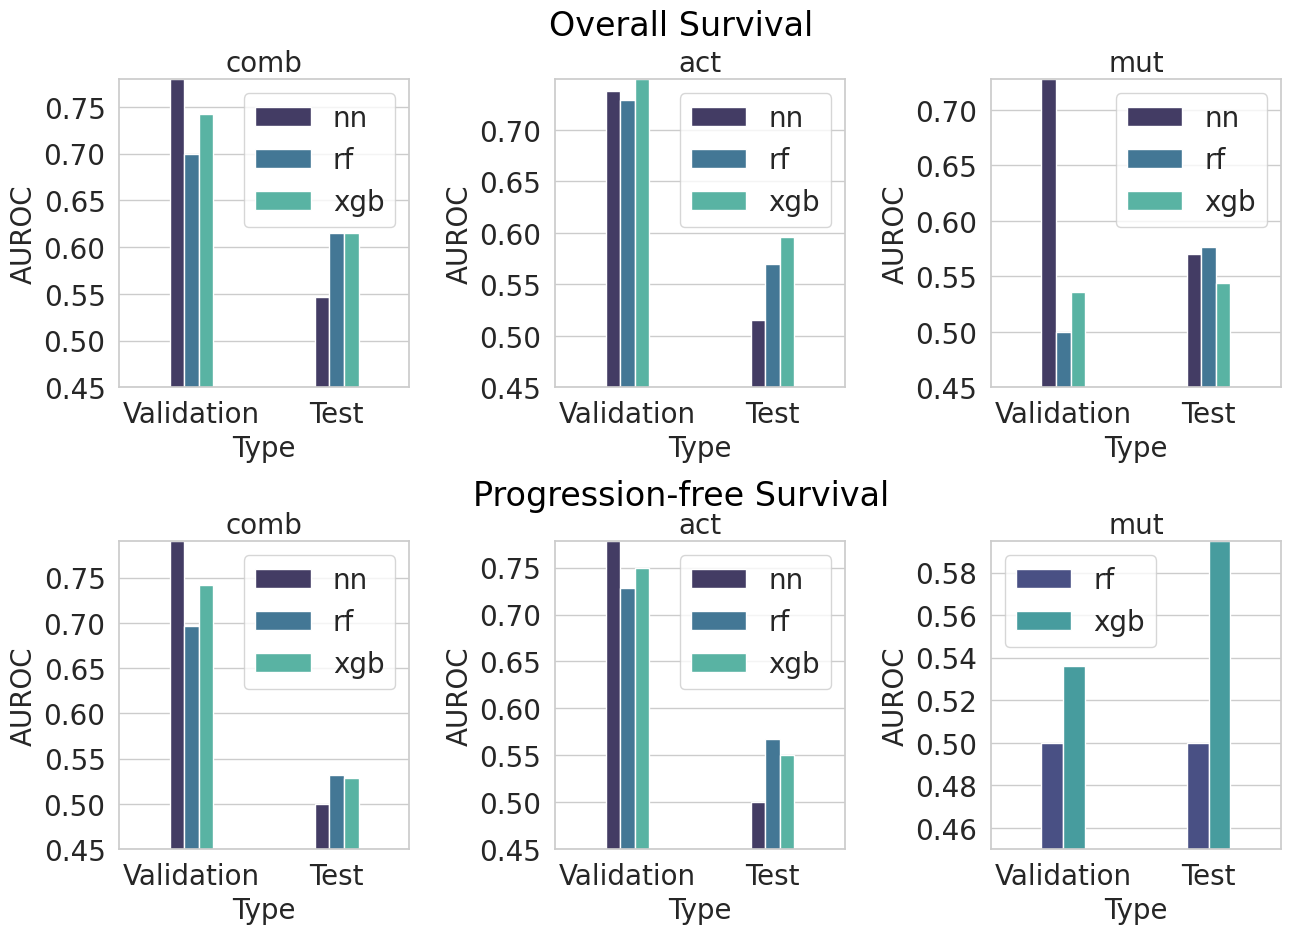

In [126]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i, data_type in enumerate(['comb', 'act', 'mut', 'comb', 'act', 'mut']):
    if i < 3:
        res_data = res_comb.loc[(res_comb['outcome'] == 'OS') & (res_comb['data_type'] == data_type)]
        res_data = res_data[['model', 'val_auroc', 'test_auroc_mean']]
        ymax = max(res_data['val_auroc'].max(), res_data['test_auroc_mean'].max())
        res_data.columns = ['Model', 'Validation', 'Test']
        #make all data <0.5 equal to 0.5
        res_data['Validation'] = res_data['Validation'].apply(lambda x: 0.5 if x < 0.5 else x)
        res_data['Test'] = res_data['Test'].apply(lambda x: 0.5 if x < 0.5 else x)
        res_data = res_data.melt(id_vars='Model', var_name='Type', value_name='AUROC')
        #make the size of the bars narrower
        ax = ax.flatten()
        #sort the data by model type
        res_data.sort_values(by='Model', inplace=True)
        sns.barplot(x='Type', y='AUROC', hue='Model', data=res_data, errorbar=None, ax=ax[i], palette='mako', width=0.3)
        
        ax[i].set_title(f'{data_type}')
        ax[i].set_ylim(0.45, ymax)
        #make the font bigger
        for item in ([ax[i].title, ax[i].xaxis.label, ax[i].yaxis.label] + ax[i].get_xticklabels() + ax[i].get_yticklabels()):
                item.set_fontsize(20)
        ax[i].legend(fontsize=20)
    elif i >= 3:
        res_data = res_comb.loc[(res_comb['outcome'] == 'PFS') & (res_comb['data_type'] == data_type)]
        res_data = res_data[['model', 'val_auroc', 'test_auroc_mean']]
        ymax = max(res_data['val_auroc'].max(), res_data['test_auroc_mean'].max())
        res_data.columns = ['Model', 'Validation', 'Test']
        #make all data <0.5 equal to 0.5
        res_data['Validation'] = res_data['Validation'].apply(lambda x: 0.5 if x < 0.5 else x)
        res_data['Test'] = res_data['Test'].apply(lambda x: 0.5 if x < 0.5 else x)
        res_data = res_data.melt(id_vars='Model', var_name='Type', value_name='AUROC')
        #make the size of the bars narrower
        ax = ax.flatten()
        #sort the data by model type
        res_data.sort_values(by='Model', inplace=True)
        sns.barplot(x='Type', y='AUROC', hue='Model', data=res_data, errorbar=None, ax=ax[i], palette='mako', width=0.3)
        ax[i].set_title(f'{data_type}')
        ax[i].set_ylim(0.45, ymax)
        #make the font bigger
        for item in ([ax[i].title, ax[i].xaxis.label, ax[i].yaxis.label] + ax[i].get_xticklabels() + ax[i].get_yticklabels()):
                item.set_fontsize(20)
        ax[i].legend(fontsize=20)
plt.figtext(0.5,0.95, "Overall Survival", ha="center", va="top", fontsize=24, color="black")      
plt.figtext(0.5,0.48, "Progression-free Survival", ha="center", va="top", fontsize=24, color="black")
plt.subplots_adjust(hspace = 0.5, wspace=0.5)
plt.savefig('figures/pdx_ki_os_pfs.png', dpi=300, bbox_inches='tight')